# COMP90051 Project 2

In [2]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [3]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        
        
        pass
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        pass

In [4]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """

    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        self.values = [Q0 for col in range(narms)]
        self.counts = [0 for col in range(narms)]

    def play(self, tround, context=None):
        if np.random.random() > self.epsilon:
            #Exploit
            max_index = [index + 1 for index, value in enumerate(self.values) if value == max(self.values)]
            return max_index[np.random.randint(len(max_index))]
        else:
            # Explore 
            return np.random.randint(self.narms) + 1

    def update(self, arm, reward, context=None):
        if self.counts[arm] == 0:
            self.values[arm] = 0
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        if value == np.inf:
            value = 0
        new_value = ((n - 1) * value + reward) / float(n)
        #update the new value to the list
        self.values[arm] = new_value

In [5]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """

    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        self.counts = [0 for col in range(narms)]
        self.values = [Q0 for col in range(narms)]
        self.Q0 = Q0


    def play(self, tround, context=None):
        ucb_values = [0.0 for arm in range(self.narms)]
        for arm in range(self.narms):
            if self.counts[arm] == 0:
                ucb_values[arm] = self.Q0
            else:
                standard_deviation = np.sqrt((self.rho * np.log(tround)) / float(self.counts[arm]))
                ucb_values[arm] = self.values[arm] + standard_deviation
        max_index = [index + 1 for index, value in enumerate(ucb_values) if value == max(ucb_values)]
        return max_index[np.random.randint(len(max_index))]

    def update(self, arm, reward, context=None):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        if value == np.inf:
            value = 0
        new_value = ((n - 1) * value + reward) / float(n)
        #update the new value to the list
        self.values[arm] = new_value

## 2. Off-Policy Evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit

    Arguments
    =========
    mab : instance of MAB

    arms : 1D int array, shape (nevents,)
        integer arm id for each event

    rewards : 1D float array, shape (nevents,)
        reward received for each event

    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally)
        for each event.

    nrounds : int, optional
        number of matching events to evaluate `mab` on.

    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    reward_list = []
    index=0
    for i in range(1,nrounds+1):
        while True:
            if index > len(arms):
                return reward_list
            arm = mab.play(i, contexts[index])
            if(arm == arms[index]):
                mab.update(arms[index] - 1, rewards[index], contexts[index])
                # arms numbers in dataset in dataset are from 1 to 10. but in list are from 0 to 9
                reward_list.append(rewards[index])
                index+=1
                break
            else:
                index+=1
    return reward_list

In [7]:
events={'arms':[],'rewards':[],'contexts':[]}
# load the data from txt
with open("dataset.txt","r") as f:
    for line in f:
        sub = line.split(" ")
        events['arms'].append(int(sub[0]))
        events['rewards'].append(float(sub[1]))
        events['contexts'].append((sub[2:102]))

arms = events['arms']
rewards = events['rewards']
contexts = np.array(events['contexts'],float)

In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.24


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.1725


## 3. Contextual Bandits

In [10]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of armsa

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """

    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.counts = [0 for col in range(narms)]
        self.A = np.zeros((narms, ndims, ndims))
        self.b = np.zeros((narms, ndims))
        self.p = np.empty(self.narms)

    def play(self, tround, context):
        context = context.reshape(self.narms, self.ndims)
        for arm in range(self.narms):

            if self.counts[arm] == 0:
                #when arm is new, Initialize matrix and update the arm counts
                self.A[arm] = np.eye(self.ndims)
                self.counts[arm] +=1
            theta = (inv(self.A[arm]).dot(self.b[arm]))
            self.p[arm] = theta.dot(context[arm]) + self.alpha * np.sqrt(
                (context[arm]).dot(inv(self.A[arm])).dot(context[arm]))
        max_index = [index + 1 for index, value in enumerate(self.p) if value == max(self.p)]
        return max_index[np.random.randint(len(max_index))]

    def update(self, arm, reward, context):
        context = context.reshape(self.narms, self.ndims)
        self.A[arm] += np.outer(context[arm],context[arm])
        self.b[arm] += reward * context[arm]
        #update values of two lists

In [11]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Evaluation
### 4.A.

In [12]:
def calculate(results_LinUCB, rounds):
    #calculate the cummulative sum of the list
    cummulative_list = []
    for round in rounds:
        value = np.sum(results_LinUCB[:round])/round
        cummulative_list.append(value)
    return cummulative_list

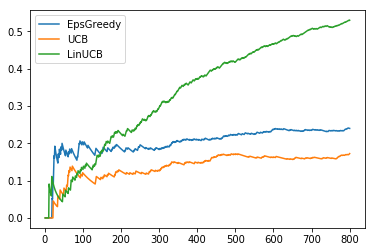

In [13]:
rounds = np.arange(800) + 1
plt.plot(rounds, calculate(results_EpsGreedy,rounds), label = 'EpsGreedy')
plt.plot(rounds, calculate(results_UCB, rounds), label = 'UCB')
plt.plot(rounds, calculate(results_LinUCB,rounds), label='LinUCB')
plt.legend()

### 4.B.

In [14]:
alpha_list = np.linspace(0, 1, 50)
#set a list to record the value of alpha from 0 to 1
rewards_list = []
for alpha in alpha_list:
    rewards_list.append(np.mean(offlineEvaluate(LinUCB(10, 10, alpha), arms, rewards, contexts, 800)))


When the value of alpha is 0.020, the LinUCB works best. The best mean reward is 0.723.


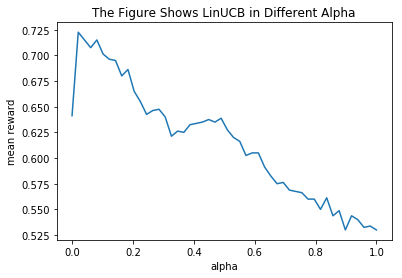

In [24]:
plt.title('The Figure Shows LinUCB in Different Alpha')
plt.plot(alpha_list,rewards_list)
plt.xlabel('alpha')
plt.ylabel('mean reward')

best_reward = np.max(rewards_list)
best_index = np.argmax(rewards_list)
best_alpha = alpha_list[best_index]
print("When the value of alpha is %0.3f, the LinUCB works best. The best mean reward is %0.3f." % (best_alpha, best_reward))

## 5. KernelUCB

In [ ]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        
    
    def play(self, tround, context):
        
    
    def update(self, arm, reward, context):
        
    